In [25]:
import numpy as np
import pickle
import os

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [26]:
run_local = False # change to False if using google drive
from enum import Enum

if run_local: # place pickle file in same directory as this ipynb
    data_path = os.path.join(os.getcwd(), "parsed_data", "parsed_data_final_srishti.pkl")
    with open(data_path, "rb") as file:
        data = pickle.load(file)
else:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
    with open(data_path, "rb") as file:
        data = pickle.load(file)

print(f"Shape of full dataset: {data.shape}")
data = data[:, :-1, :]


class FeatureOption(Enum):
    VEHICLE_ONLY = 1 # Vehicle features only
    VEHICLE_AND_PEDESTRIAN = 2 # Vehicle and Pedestrian features:
    VEHICLE_PEDESTRIAN_ROADGRAPH = 3 # Vehicle and Pedestrian and Roadgraph features:
    VEHICLE_PEDESTRIAN_ROADGRAPH_AND_BICYCLE = 4 # Vehicle and Pedestrian and Roadgraph and Bicycle features

feature_option = FeatureOption.VEHICLE_PEDESTRIAN_ROADGRAPH_AND_BICYCLE # choose from: VEHICLE_ONLY, VEHICLE_AND_PEDESTRIAN, VEHICLE_PEDESTRIAN_ROADGRAPH, VEHICLE_PEDESTRIAN_ROADGRAPH_AND_BICYCLE

if feature_option == FeatureOption.VEHICLE_ONLY: # Vehicle Only
    data = data[:, :, 1:6]
elif feature_option == FeatureOption.VEHICLE_AND_PEDESTRIAN: # Vehicle and pedestrian
    data = data[:, :, 1:8]

    first_set = data[:, :, :-2]
    last_two_values = data[:, :, -2:]

    # Compute min and max for the last two features
    min_val_last_two = last_two_values.min(axis=(0, 1), keepdims=True)  # Shape: (1, 1, 2)
    max_val_last_two = last_two_values.max(axis=(0, 1), keepdims=True)  # Shape: (1, 1, 2)

    # Normalize the last two values using their specific min and max
    normalized_last_two = (last_two_values - min_val_last_two) / (max_val_last_two - min_val_last_two + 1e-8)

    # Update the data with normalized last two features
    data[:, :, -2:] = normalized_last_two
elif feature_option == FeatureOption.VEHICLE_PEDESTRIAN_ROADGRAPH: # Vehicle, pedestrian, and roadgraph
    vehicle_pedestrian = data[:, :, 1:8]
    roadgraph = data[:, :, 10:]
    data = np.concatenate((vehicle_pedestrian, roadgraph), axis = 2)
elif feature_option == FeatureOption.VEHICLE_PEDESTRIAN_ROADGRAPH_AND_BICYCLE: # vehicle, pedestrian, roadgraph and bicycle
    # data = data[:, :-1, :]

    # cyclist normalization
    last_three_values = data[:, :, -6:-4]
    min_val_last_two = last_three_values.min(axis=(0, 1), keepdims=True)  # Shape: (1, 1, 2)
    max_val_last_two = last_three_values.max(axis=(0, 1), keepdims=True)  # Shape: (1, 1, 2)
    normalized_three = (last_three_values - min_val_last_two) / (max_val_last_two - min_val_last_two + 1e-8)
    data[:, :, -6:-4] = normalized_three
    cyclist_features = data[:, :, -6:-4]

    # roadgraph normalization
    last_three_values = data[:, :, -4:-1]
    min_val_last_two = last_three_values.min(axis=(0, 1, 2), keepdims=True)  # Shape: (1, 1, 2)
    max_val_last_two = last_three_values.max(axis=(0, 1, 2), keepdims=True)  # Shape: (1, 1, 2)
    normalized_three = (last_three_values - min_val_last_two) / (max_val_last_two - min_val_last_two + 1e-8)
    data[:, :, -4:-1] = normalized_three
    road_graph_features = data[:, :, -4:]

    data = data[:, :, 1:8]

    # This is for vehicle + pedestrians + roadgraphs
    # another_data = data[:, :, 1:8]
    # new_data = data[:, :, 10:]
    # data = np.concatenate((another_data, new_data), axis = 2)

    first_set = data[:, :, :-2]
    last_two_values = data[:, :, -2:]
    min_val_last_two = last_two_values.min(axis=(0, 1), keepdims=True)  # Shape: (1, 1, 2)
    max_val_last_two = last_two_values.max(axis=(0, 1), keepdims=True)  # Shape: (1, 1, 2)
    normalized_last_two = (last_two_values - min_val_last_two) / (max_val_last_two - min_val_last_two + 1e-8)
    data[:, :, -2:] = normalized_last_two

    data = np.concatenate((data, cyclist_features), axis = 2)
    data = np.concatenate((data, road_graph_features), axis = 2)

else:
    raise Exception("Invalid Choice")





X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print("For each input state: X position, Y position, X velocity, Y velocity, Heading")
print("For each output state: X velocity, Y velocity")
print("Feature Type: ", feature_option)
print("\nTraining Data:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print("\nValidation Data:")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of full dataset: (2933, 91, 14)
For each input state: X position, Y position, X velocity, Y velocity, Heading
For each output state: X velocity, Y velocity
Feature Type:  FeatureOption.VEHICLE_PEDESTRIAN_ROADGRAPH_AND_BICYCLE

Training Data:
X_train shape: (2346, 80, 13)
y_train shape: (2346, 10, 13)

Validation Data:
X_val shape: (587, 80, 13)
y_val shape: (587, 10, 13)


In [27]:
import torch
import torch.nn as nn

class TrajectoryTransformer(nn.Module):
    def __init__(self, input_size, model_dim, num_heads, num_layers, output_features=2, output_timesteps=10, max_seq_length=100):
        super(TrajectoryTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, model_dim)
        self.positional_encoding = nn.Parameter(torch.randn(max_seq_length, model_dim))
        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=4 * model_dim,
            dropout=0.5 #dropout=0.1
        )
        self.fc = nn.Linear(model_dim, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        batch_size, seq_length, input_size = x.size()
        src = self.embedding(x) + self.positional_encoding[:seq_length]  # Add positional encoding
        src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, model_dim)

        tgt = torch.zeros_like(src)  # Dummy target (for autoregressive tasks, replace with actual decoder inputs if needed)

        # Pass through the Transformer
        output = self.transformer(src, tgt)
        output = output[-1]  # Take the last sequence position
        output = self.fc(output)
        return output.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, 2)



In [28]:
%cd /content/drive/MyDrive/CS7643Group/Loss_Architectures/

/content/drive/MyDrive/CS7643Group/Loss_Architectures


In [30]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from loss_functions import get_loss_function

# Initialize lists to store loss history
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10, loss_fn=nn.MSELoss()):
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

    best_val_loss = float('inf')
    model_save_path = "transformer_external_model.pth"  # Save path for the best model

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        epoch_train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")

            optimizer.zero_grad()
            predictions = model(batch_x)
            # print(predictions.shape)
            loss = loss_fn(predictions, batch_y, batch_x[:, 0, :2])
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_train_loss += loss.item()

        scheduler.step()

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
                predictions = model(batch_x)
                loss = loss_fn(predictions, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()

            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            print(f'Validation Loss: {avg_val_loss:.4f}')

            # Save the model if it has the best validation loss (Comment out if you don't want to save)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), model_save_path)
                print(f"Saved best model with validation loss: {best_val_loss:.4f}")

    print(f"Training complete. Best validation loss: {best_val_loss:.4f}. Model saved to {model_save_path}.")


train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
# Mess with batch size here
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


input_size = X_train.shape[2]
# print(input_size)
hidden_size = 64 # changeable
input_size = X_train.shape[2]

model_dim = 16  # Adjustable
num_heads = 1  # Adjustable
num_layers = 1  # Adjustable

model = TrajectoryTransformer(input_size, model_dim, num_heads, num_layers, output_features=2, output_timesteps=10).to("cuda")

loss_weights = { # Update weights of different loss terms
    "position_loss": 1.0,
    "velocity_loss": 0.5,
    "smoothness_loss": 0.25,
    "terminal_loss": 2.0,
    "delta_loss": 0.5
}
# Customize loss function here (Everything is True/False except time_weighting_scheme)
loss_fn = get_loss_function(
    "trajectory_loss", # trajectory_loss is just position loss if everything else is False
    use_velocity_loss=True,
    use_smoothness_loss=True,
    use_terminal_loss=True,
    time_weighting_scheme='Exponential',  #None, Linear, Exponential
    use_delta_loss=True,
    prediction_horizon=10, # change to match predicted timesteps (used for time)
    loss_weights=loss_weights # defaults to ALL = 1.0 if not included
) # Add more lines as new loss functions are added

# mess with epochs, initial_lr and T_max here
train_model(model, train_loader, val_loader, num_epochs=100, initial_lr=1e-2, T_max=100, loss_fn=loss_fn)


Epoch [1/100], Training Loss: 27025.3380, LR: 0.009998
Validation Loss: 13276.0344
Saved best model with validation loss: 13276.0344
Epoch [2/100], Training Loss: 25987.2655, LR: 0.009990
Validation Loss: 12813.2497
Saved best model with validation loss: 12813.2497
Epoch [3/100], Training Loss: 25450.9428, LR: 0.009978
Validation Loss: 12409.5781
Saved best model with validation loss: 12409.5781
Epoch [4/100], Training Loss: 24997.0862, LR: 0.009961
Validation Loss: 11908.2038
Saved best model with validation loss: 11908.2038
Epoch [5/100], Training Loss: 24256.6107, LR: 0.009938
Validation Loss: 11738.7746
Saved best model with validation loss: 11738.7746
Epoch [6/100], Training Loss: 23891.4026, LR: 0.009911
Validation Loss: 11599.9615
Saved best model with validation loss: 11599.9615
Epoch [7/100], Training Loss: 23683.9458, LR: 0.009880
Validation Loss: 11736.7035
Epoch [8/100], Training Loss: 23494.5685, LR: 0.009843
Validation Loss: 11439.6335
Saved best model with validation los

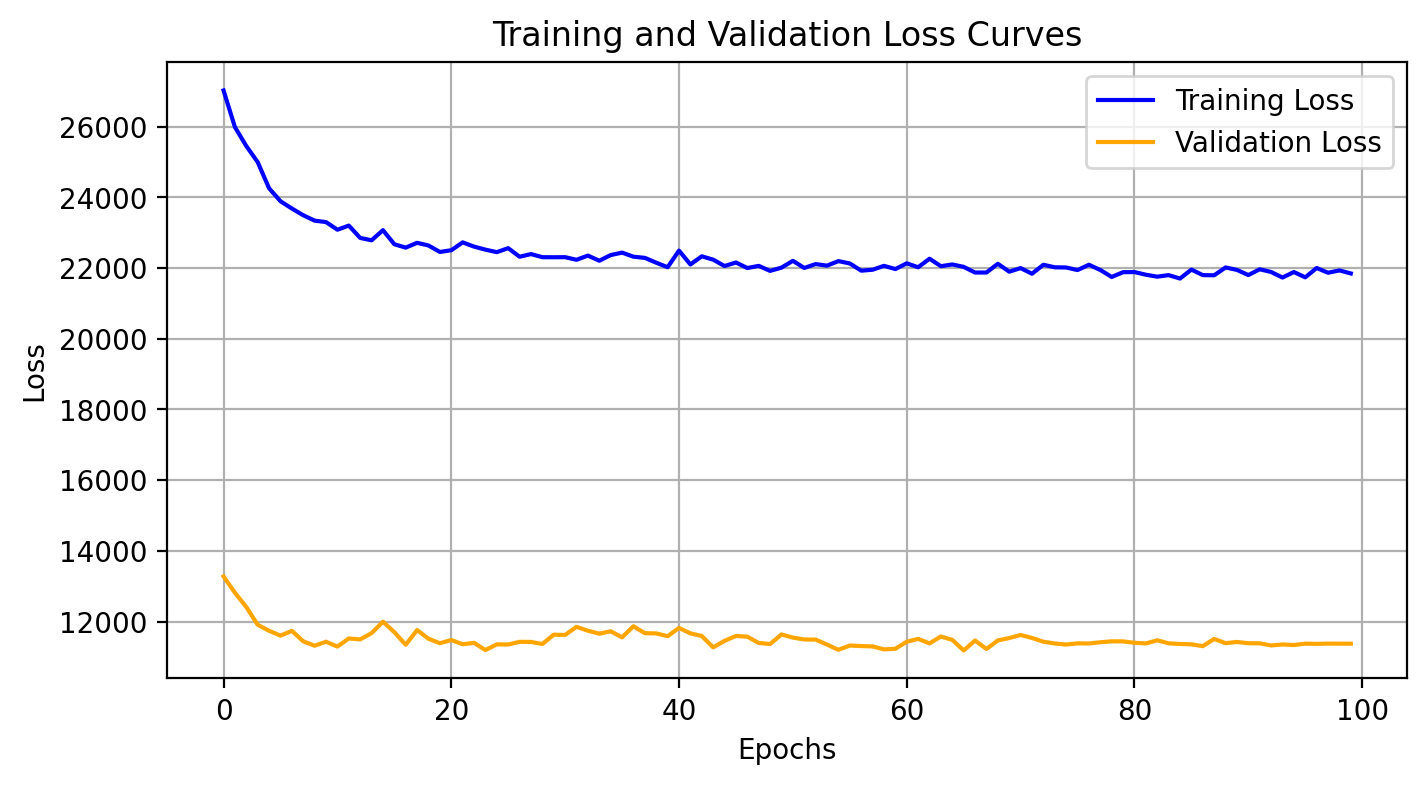

In [31]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

In [32]:
from metrics import (
    compute_predicted_positions,
    compute_mean_ade,
    compute_fde,
    compute_directional_accuracy,
    compute_linear_wade,
    compute_exponential_wade
) # add new imports here as new metrics created

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")
# Compute metrics
with torch.no_grad():
    pred_position = compute_predicted_positions(model, x, y)
    mean_ade = compute_mean_ade(pred_position, y)
    fde = compute_fde(pred_position, y)
    directional_accuracy = compute_directional_accuracy(pred_position, y)
    l_wade = compute_linear_wade(pred_position, y)

    alpha = 0.5 #Smaller alpha -> more uniform weights, larger alpha -> more emphasis on earlier timesteps (defaults to 0.1)
    e_wade = compute_exponential_wade(pred_position, y, alpha=alpha)

print(f"Mean Average Displacement Error (MADE): {mean_ade:.4f}")
print(f"Final Displacement Error (FDE): {fde:.4f}")
print(f"Directional Accuracy (DA): {directional_accuracy:.4f}")
print(f"Linear Weighted Average Displacement Error (LWADE): {l_wade:.4f}")
print(f"Exponential Weighted Average Displacement Error (EWADE) with alpha={alpha}: {e_wade:.4f}")
print(f"Overall Score (Lower is better) = {e_wade + 0.5 * fde - 0.5 * directional_accuracy}")

Mean Average Displacement Error (MADE): 6.3449
Final Displacement Error (FDE): 13.7586
Directional Accuracy (DA): 0.3477
Linear Weighted Average Displacement Error (LWADE): 0.4389
Exponential Weighted Average Displacement Error (EWADE) with alpha=0.5: 0.2720
Overall Score (Lower is better) = 6.977479174733162


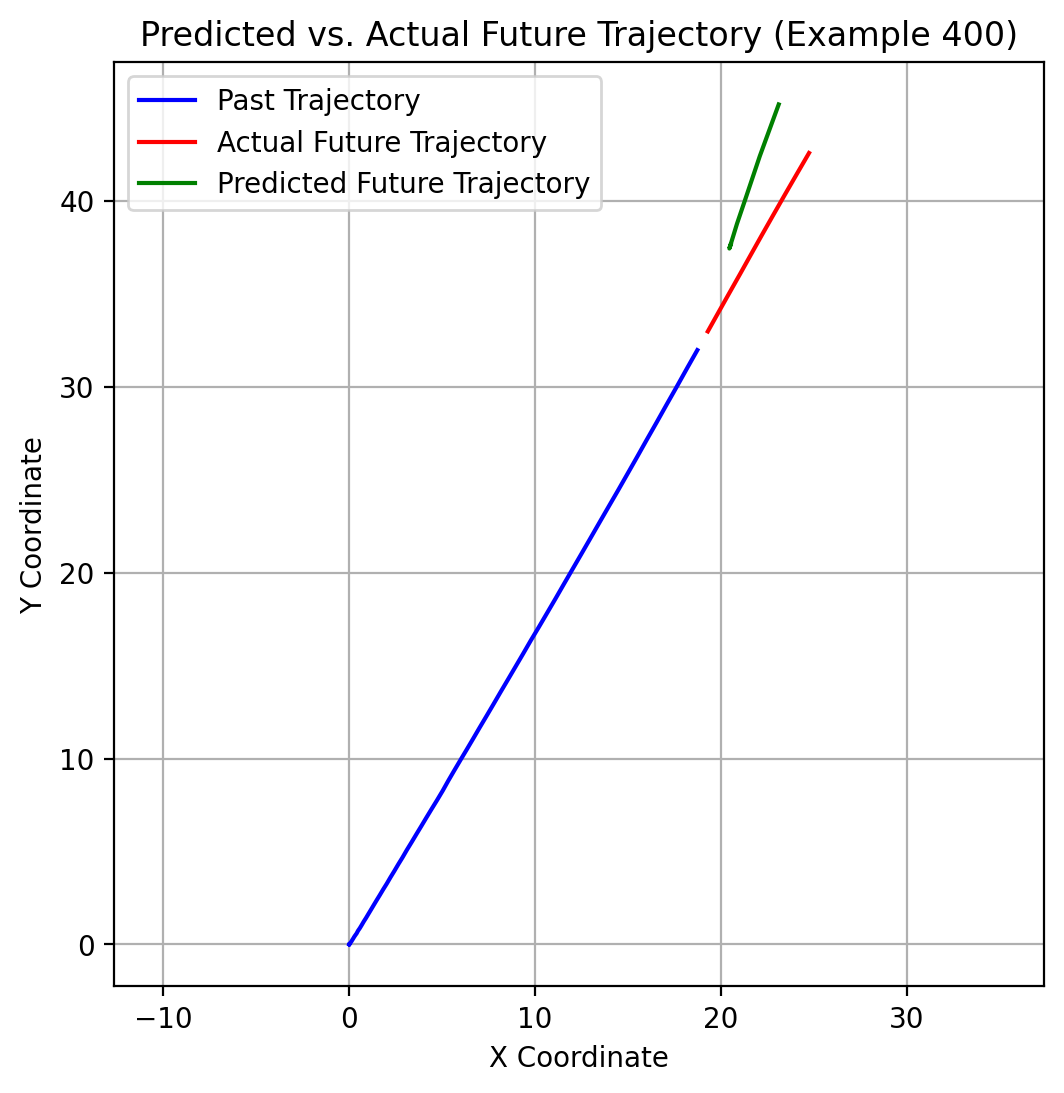

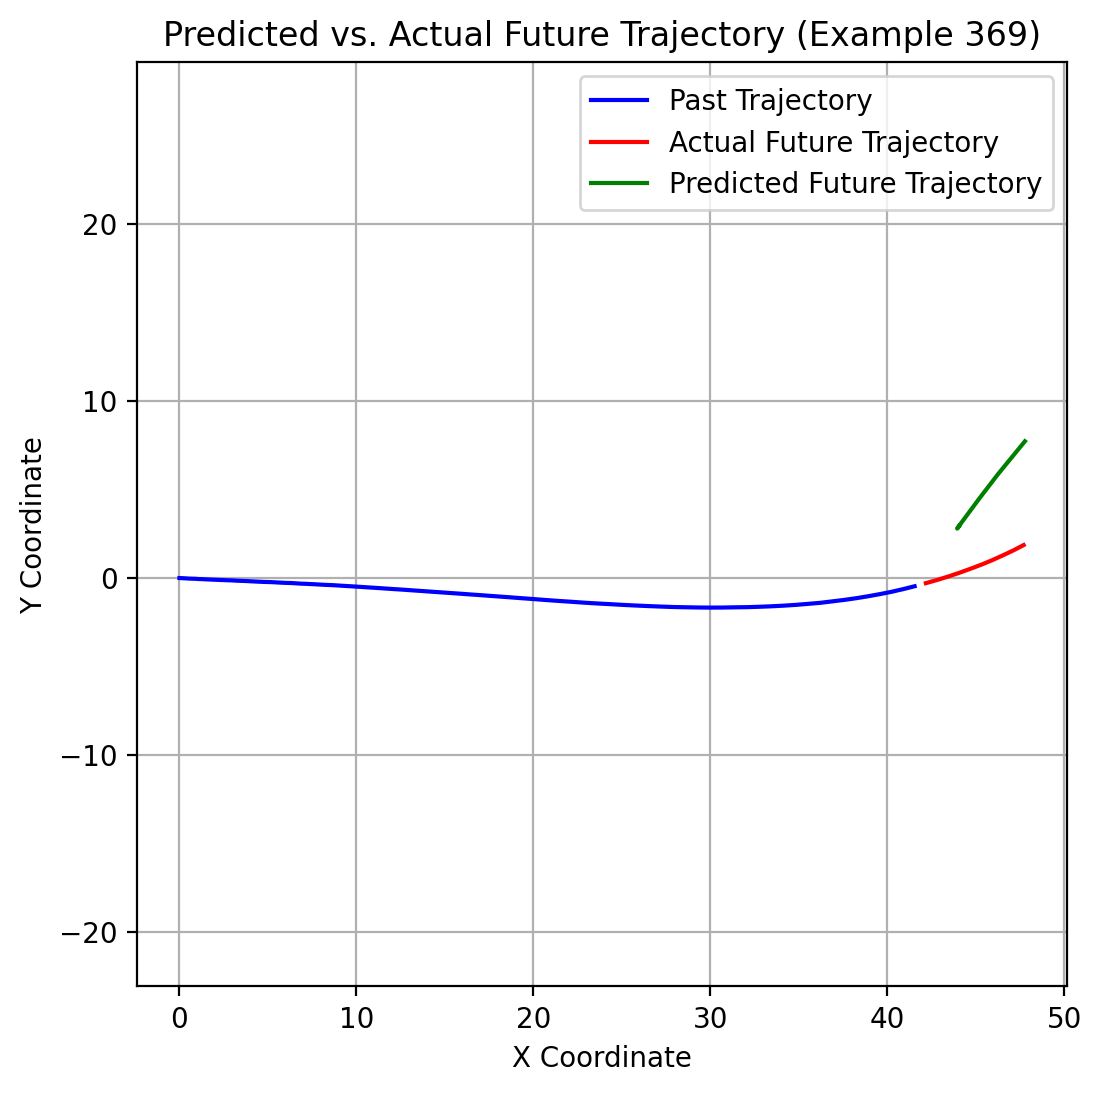

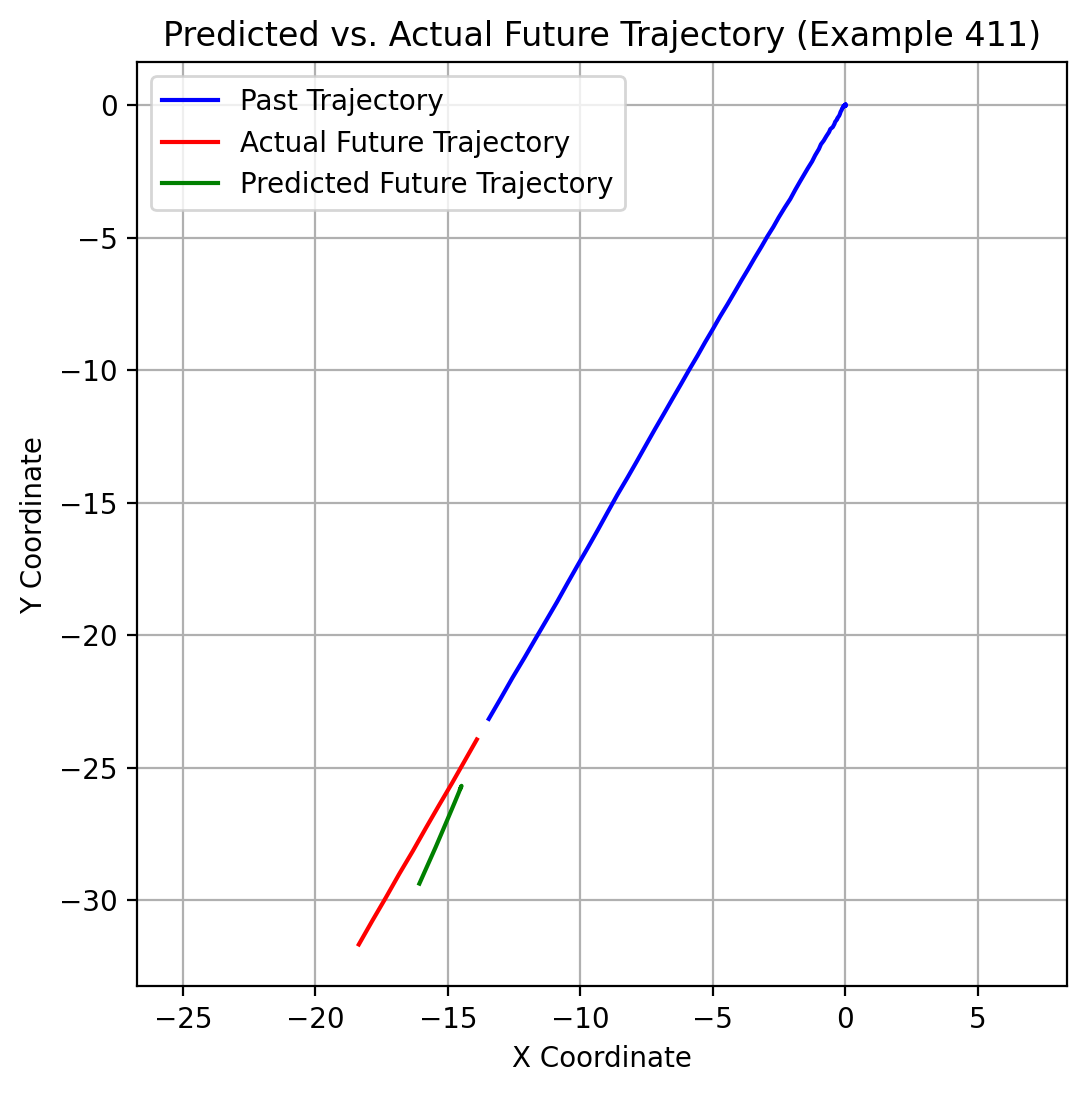

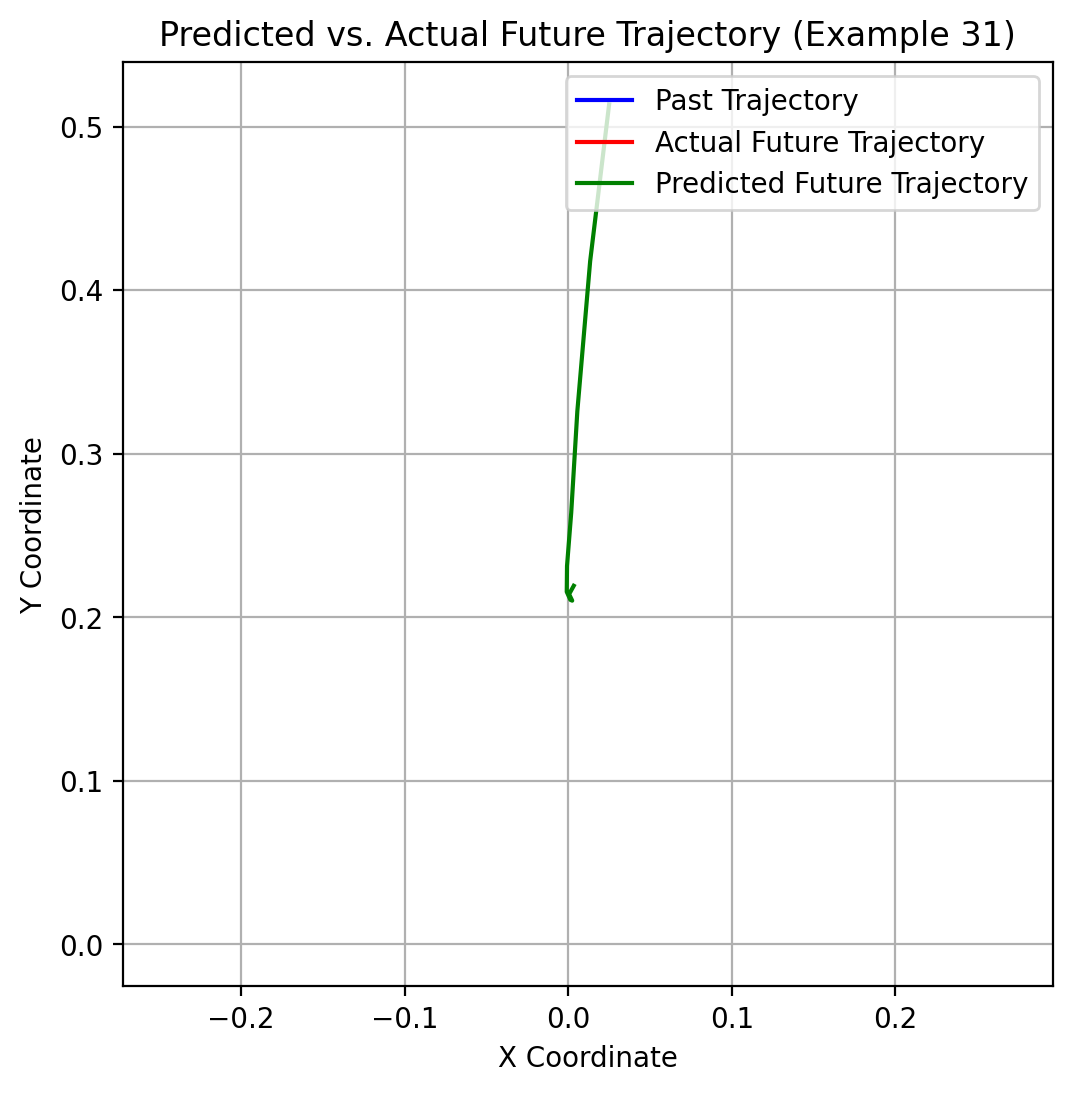

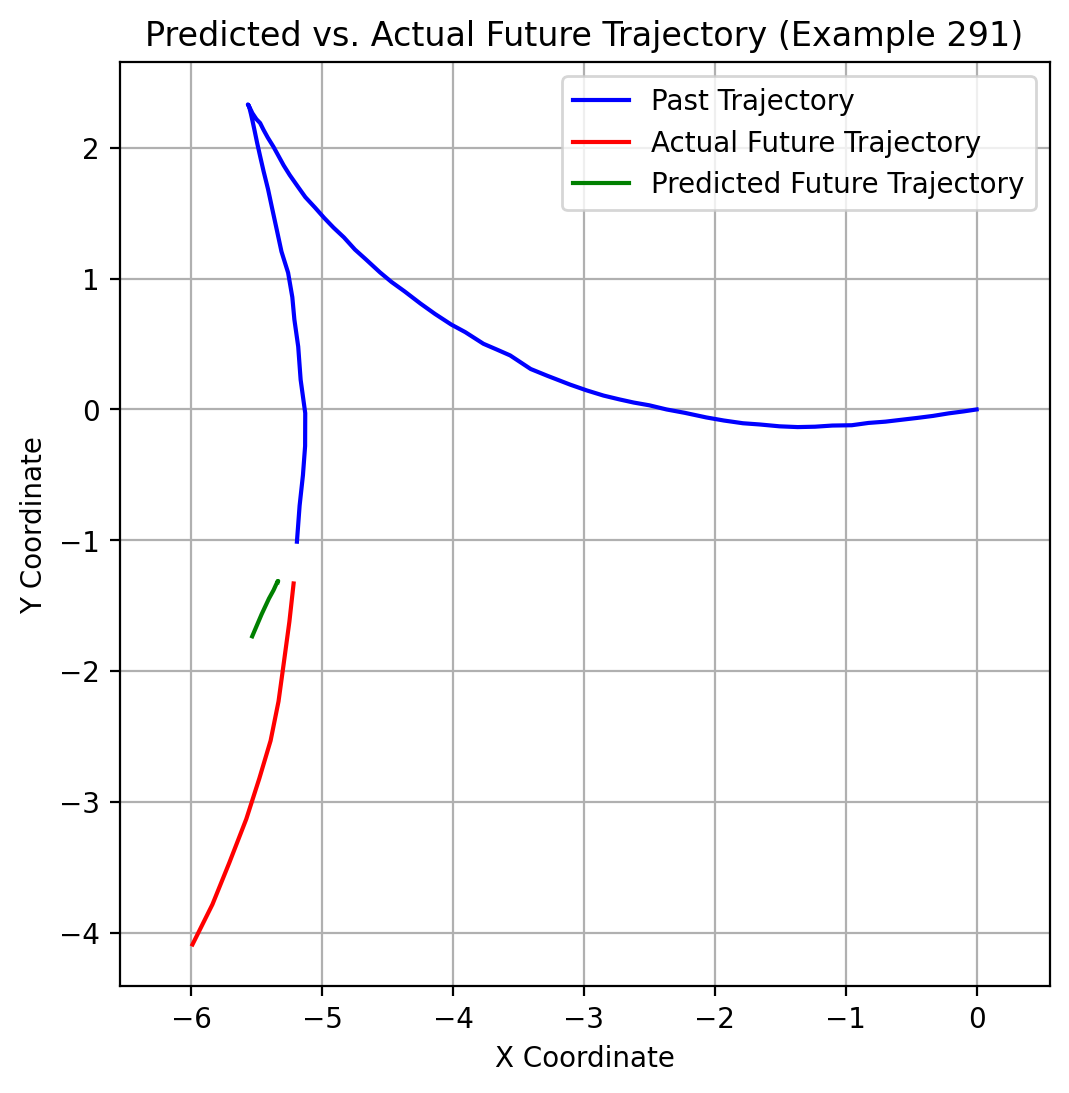

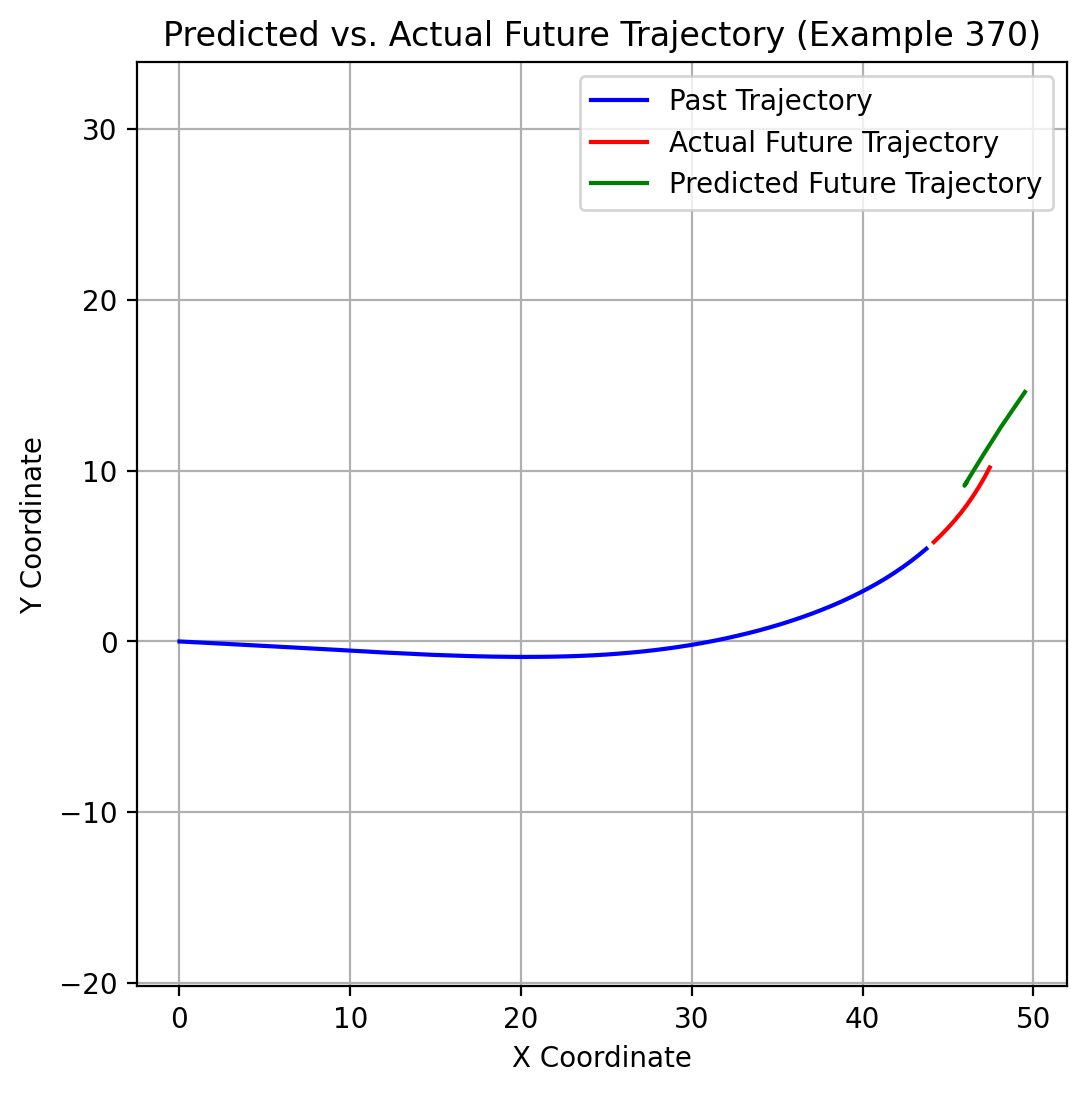

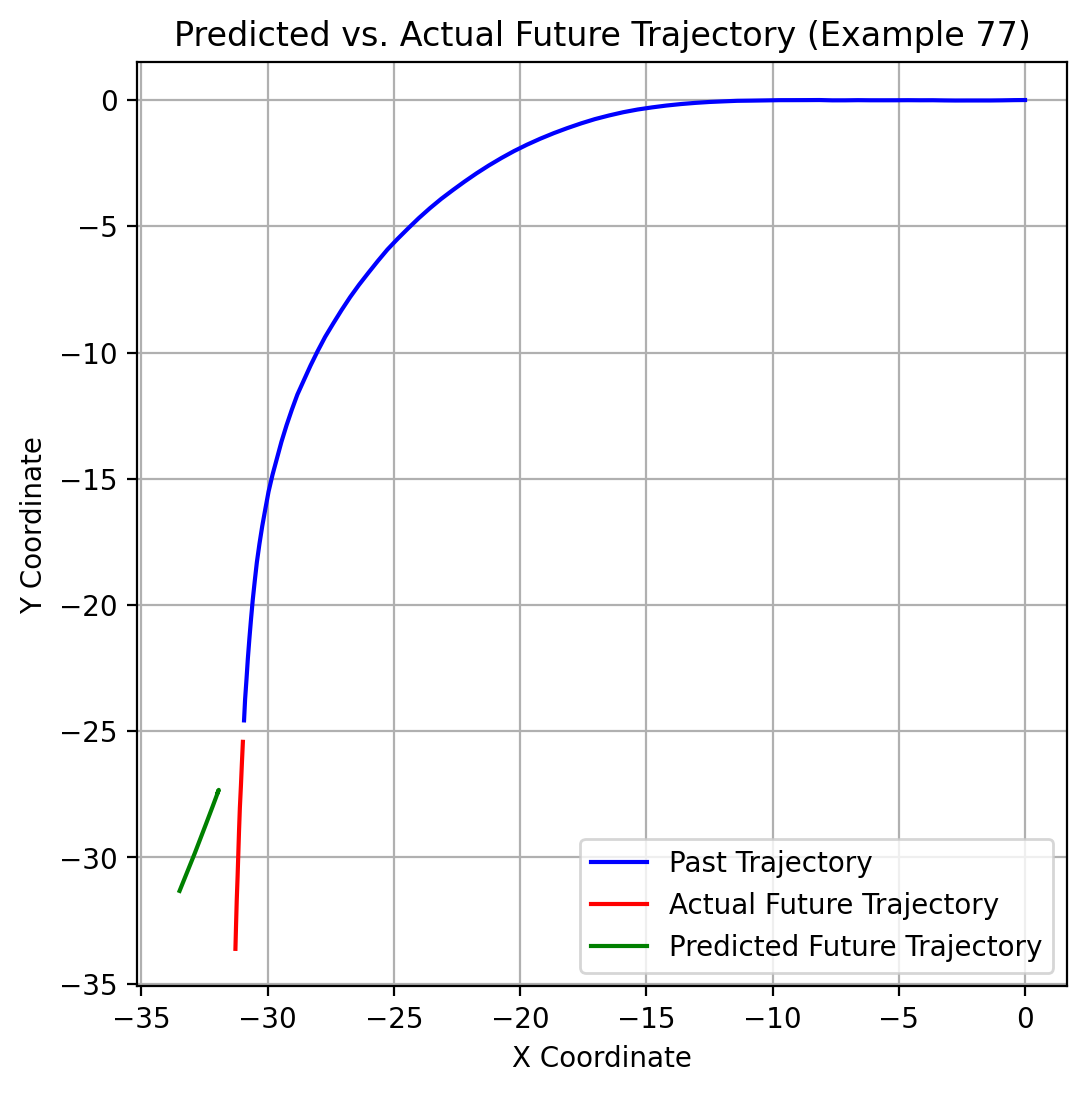

In [33]:
# Example 400 - straight path towards top right
example_index = 400
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 369 - very slight curve
example_index = 369
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 411 - straight path towards bottom left
example_index = 411
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 31 - No movement
example_index = 31
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 291 - Sharp turn
example_index = 291
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 370 - Smooth slight turn
example_index = 370
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# Example 77 - smooth 90 degree turn
example_index = 77
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# Plot the trajectory
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()